In [82]:
import keras
import pandas as pd
import numpy as np
from keras.layers import *
from keras.activations import *
from keras.callbacks import *
from keras.optimizers import *
from keras.models import *
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from scipy import signal
import stldecompose

In [83]:
data_orig = pd.read_csv('../data/files/multiple_concatenated_tickers.csv')
data_orig.tail()

,Index,QQQ.Open,QQQ.High,QQQ.Low,QQQ.Close,QQQ.Volume,QQQ.Adjusted,TSLA.Open,TSLA.High,TSLA.Low,...,XLU.Low,XLU.Close,XLU.Volume,XLU.Adjusted,XLRE.Open,XLRE.High,XLRE.Low,XLRE.Close,XLRE.Volume,XLRE.Adjusted
844,2019-05-13,180.289993,181.259995,178.059998,178.580002,67185800,178.580002,232.009995,232.470001,224.500000,...,57.700001,58.580002,20096300,58.580002,35.869999,36.169998,35.799999,36.110001,3392100,36.110001
845,2019-05-14,179.520004,181.630005,178.860001,180.539993,43360600,180.539993,229.300003,234.500000,228.000000,...,58.080002,58.189999,17609400,58.189999,36.180000,36.389999,36.099998,36.240002,3984400,36.240002
846,2019-05-15,179.350006,183.550003,179.309998,183.089996,40944500,183.089996,229.320007,232.440002,225.250000,...,58.020000,58.090000,14577500,58.090000,36.240002,36.610001,36.099998,36.480000,3478200,36.480000
847,2019-05-16,183.169998,186.070007,182.949997,184.929993,39281200,184.929993,229.490005,231.000000,226.500000,...,57.869999,58.480000,13908300,58.480000,36.480000,36.840000,36.450001,36.689999,2834200,36.689999
848,2019-05-17,183.100006,185.580002,182.880005,183.039993,44669400,183.039993,221.960007,222.240005,208.919998,...,58.139999,58.779999,10477100,58.779999,36.520000,36.709999,36.439999,36.639999,3403200,36.639999


In [84]:
vol_data_orig = pd.read_csv('../data/files/multiple_concatenated_tickers_volatility.csv')
vol_data_orig.tail()

,Index,volatilityQQQ,volatilityTSLA,volatilityMSFT,volatilityINTC,volatilityAAPL,volatilityNFLX,volatilityAMZN,volatilityFB,volatilityGOOG,...,volatilityXLB,volatilityXLI,volatilityXLY,volatilityXLP,volatilityXLV,volatilityXLF,volatilityXLK,volatilityXTL,volatilityXLU,volatilityXLRE
844,2019-05-13,0.227654,0.513169,0.269802,0.346441,0.471247,0.324958,0.283485,0.235015,0.217935,...,0.204486,0.201990,0.195013,0.130390,0.160335,0.191713,0.229865,0.226462,0.161205,0.128506
845,2019-05-14,0.246418,0.526124,0.268239,0.367193,0.365657,0.278292,0.295260,0.233604,0.208531,...,0.207505,0.219360,0.208065,0.117154,0.165486,0.203228,0.263019,0.251037,0.154980,0.129728
846,2019-05-15,0.267037,0.457982,0.268356,0.385485,0.387684,0.339966,0.315566,0.309336,0.311047,...,0.207547,0.220494,0.214447,0.124270,0.164090,0.201220,0.277943,0.257279,0.154745,0.133600
847,2019-05-16,0.255270,0.347390,0.272957,0.331132,0.365942,0.332683,0.276670,0.292490,0.299280,...,0.217383,0.214247,0.209255,0.124754,0.164555,0.203585,0.277461,0.227552,0.156189,0.132117
848,2019-05-17,0.257535,0.485160,0.273593,0.330290,0.366657,0.330412,0.291928,0.292859,0.306577,...,0.208028,0.215737,0.210142,0.126243,0.159069,0.203535,0.277591,0.228449,0.153681,0.129404


In [85]:
data_orig = data_orig\
  .merge(vol_data_orig, how="inner", left_on=data_orig.Index, right_on=vol_data_orig.Index).fillna(method="ffill")\
  .drop(["key_0", "Index_y"], axis=1)\
  .rename(columns={'Index_x':'Index'})

In [86]:
from urllib.request import *
from io import StringIO
import pandas as pd

def df_from_fred(setname):
    # Make GET Request
    response = urlopen(url_for(setname))
    # Read response data
    data = response.read()
    # Convert binary text to utf-8
    text = data.decode('utf-8')
    # Convert text file to pandas dataframe
    TEXTDATA = StringIO(text)
    df = pd.read_csv(TEXTDATA, sep=",")
    return df

def url_for(series):
    """function takes FRED series name as input. For example, GDPC1, or HOUST."""
    return "https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=968&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id="+series+"&scale=left&cosd=1947-01-01&coed=2019-01-01&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Quarterly&fam=avg&fgst=lin&fgsnd=2009-06-01&line_index=1&transformation=lin&vintage_date=2019-05-07&revision_date=2019-05-07&nd=1947-01-01"


In [89]:
# Vital Economic indicators: https://gist.github.com/ngopal/262fce10a7fa4a8467f0c61a13c85dc5
GDPC1 = df_from_fred("GDPC1")
time.sleep(5)
M2 = df_from_fred("M2")
time.sleep(5)
CPALTT01USQ657N = df_from_fred("CPALTT01USQ657N")
time.sleep(5)
PPIACO = df_from_fred("PPIACO")
time.sleep(5)
UMCSENT = df_from_fred("UMCSENT")
time.sleep(5)
PAYEMS = df_from_fred("PAYEMS")
time.sleep(5)
RRSFS = df_from_fred("RRSFS")
time.sleep(5)
HOUST = df_from_fred("HOUST")
time.sleep(5)
ISRATIO = df_from_fred("ISRATIO")
time.sleep(5)
SP500 = df_from_fred("SP500")
time.sleep(5)

# Thoughts
FEDFUNDS = df_from_fred("FEDFUNDS")
time.sleep(5)
UNRATE = df_from_fred("UNRATE")
time.sleep(5)
T10Y2Y = df_from_fred("T10Y2Y")
time.sleep(5)
CBBTCUSD = df_from_fred("CBBTCUSD")
time.sleep(5)

# Others
IPMAN = df_from_fred("IPMAN")
time.sleep(5)
MPU9900063 = df_from_fred("MPU9900063")
time.sleep(5)
PCU33443344 = df_from_fred("PCU33443344")
time.sleep(5)
MEHOINUSA672N = df_from_fred("MEHOINUSA672N")
time.sleep(5)
TCMDO = df_from_fred("TCMDO")
time.sleep(5)
FGTCMDODNS = df_from_fred("FGTCMDODNS")
time.sleep(5)
ADSLFAA027N = df_from_fred("ADSLFAA027N")
time.sleep(5)
NCBCMDPMVCE = df_from_fred("NCBCMDPMVCE")
time.sleep(5)
FGCCSAQ027S = df_from_fred("FGCCSAQ027S")
time.sleep(5)
ASTNITA = df_from_fred("ASTNITA")
time.sleep(5)
PCETRIM12M159SFRBDAL = df_from_fred("PCETRIM12M159SFRBDAL")
time.sleep(5)

# More
USSLIND = df_from_fred("USSLIND")
time.sleep(5)
SIPOVGINIUSA = df_from_fred("SIPOVGINIUSA")
time.sleep(5)
# nD4Q = df_from_fred("nD4Q")
# time.sleep(5)
# nGIO = df_from_fred("nGIO")
# time.sleep(5)
TEDRATE = df_from_fred("TEDRATE")
time.sleep(5)
DFII30 = df_from_fred("DFII30")
time.sleep(5)
AAA = df_from_fred("AAA")
time.sleep(5)
STLFSI = df_from_fred("STLFSI")
time.sleep(5)
CP1100USM086NEST = df_from_fred("CP1100USM086NEST")
time.sleep(5)

# In the future, add:
# Strength of dollar
# 5, 10, 30 year interest rates

In [91]:
data_orig = data_orig\
  .merge(GDPC1, how="left", left_on=data_orig.Index, right_on=GDPC1.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(M2, how="left", left_on=data_orig.Index, right_on=M2.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(CPALTT01USQ657N, how="left", left_on=data_orig.Index, right_on=CPALTT01USQ657N.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(PPIACO, how="left", left_on=data_orig.Index, right_on=PPIACO.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(UMCSENT, how="left", left_on=data_orig.Index, right_on=UMCSENT.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(PAYEMS, how="left", left_on=data_orig.Index, right_on=PAYEMS.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(RRSFS, how="left", left_on=data_orig.Index, right_on=RRSFS.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(HOUST, how="left", left_on=data_orig.Index, right_on=HOUST.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(ISRATIO, how="left", left_on=data_orig.Index, right_on=ISRATIO.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(PCETRIM12M159SFRBDAL, how="left", left_on=data_orig.Index, right_on=PCETRIM12M159SFRBDAL.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(ASTNITA, how="left", left_on=data_orig.Index, right_on=ASTNITA.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(FGCCSAQ027S, how="left", left_on=data_orig.Index, right_on=FGCCSAQ027S.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(NCBCMDPMVCE, how="left", left_on=data_orig.Index, right_on=NCBCMDPMVCE.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(ADSLFAA027N, how="left", left_on=data_orig.Index, right_on=ADSLFAA027N.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(FGTCMDODNS, how="left", left_on=data_orig.Index, right_on=FGTCMDODNS.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(TCMDO, how="left", left_on=data_orig.Index, right_on=TCMDO.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(MEHOINUSA672N, how="left", left_on=data_orig.Index, right_on=MEHOINUSA672N.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(PCU33443344, how="left", left_on=data_orig.Index, right_on=PCU33443344.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(MPU9900063, how="left", left_on=data_orig.Index, right_on=MPU9900063.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(IPMAN, how="left", left_on=data_orig.Index, right_on=IPMAN.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(SP500, how="left", left_on=data_orig.Index, right_on=SP500.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(FEDFUNDS, how="left", left_on=data_orig.Index, right_on=FEDFUNDS.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(UNRATE, how="left", left_on=data_orig.Index, right_on=UNRATE.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(T10Y2Y, how="left", left_on=data_orig.Index, right_on=T10Y2Y.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(CBBTCUSD, how="left", left_on=data_orig.Index, right_on=CBBTCUSD.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(USSLIND, how="left", left_on=data_orig.Index, right_on=USSLIND.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(SIPOVGINIUSA, how="left", left_on=data_orig.Index, right_on=SIPOVGINIUSA.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(TEDRATE, how="left", left_on=data_orig.Index, right_on=TEDRATE.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(DFII30, how="left", left_on=data_orig.Index, right_on=DFII30.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(AAA, how="left", left_on=data_orig.Index, right_on=AAA.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(STLFSI, how="left", left_on=data_orig.Index, right_on=STLFSI.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(CP1100USM086NEST, how="left", left_on=data_orig.Index, right_on=CP1100USM086NEST.DATE).fillna(method="ffill")\
  .fillna(-1)

In [94]:
data_orig.drop(['DATE_y', 'DATE_x', 'key_0'], axis=1, inplace=True)

In [95]:
list(data_orig.columns)

['Index',
 'QQQ.Open',
 'QQQ.High',
 'QQQ.Low',
 'QQQ.Close',
 'QQQ.Volume',
 'QQQ.Adjusted',
 'TSLA.Open',
 'TSLA.High',
 'TSLA.Low',
 'TSLA.Close',
 'TSLA.Volume',
 'TSLA.Adjusted',
 'MSFT.Open',
 'MSFT.High',
 'MSFT.Low',
 'MSFT.Close',
 'MSFT.Volume',
 'MSFT.Adjusted',
 'INTC.Open',
 'INTC.High',
 'INTC.Low',
 'INTC.Close',
 'INTC.Volume',
 'INTC.Adjusted',
 'AAPL.Open',
 'AAPL.High',
 'AAPL.Low',
 'AAPL.Close',
 'AAPL.Volume',
 'AAPL.Adjusted',
 'NFLX.Open',
 'NFLX.High',
 'NFLX.Low',
 'NFLX.Close',
 'NFLX.Volume',
 'NFLX.Adjusted',
 'AMZN.Open',
 'AMZN.High',
 'AMZN.Low',
 'AMZN.Close',
 'AMZN.Volume',
 'AMZN.Adjusted',
 'FB.Open',
 'FB.High',
 'FB.Low',
 'FB.Close',
 'FB.Volume',
 'FB.Adjusted',
 'GOOG.Open',
 'GOOG.High',
 'GOOG.Low',
 'GOOG.Close',
 'GOOG.Volume',
 'GOOG.Adjusted',
 'SQ.Open',
 'SQ.High',
 'SQ.Low',
 'SQ.Close',
 'SQ.Volume',
 'SQ.Adjusted',
 'TWTR.Open',
 'TWTR.High',
 'TWTR.Low',
 'TWTR.Close',
 'TWTR.Volume',
 'TWTR.Adjusted',
 'DATA.Open',
 'DATA.High',
 '

In [ ]:
# Calculate HV 20, HV 50, and HV 100 columns for all volatility cols

In [96]:
ticker_lookup = dict([(i[1].split('.')[0], int(i[0])) for i in enumerate(list(data_orig.columns)) if 'Open' in i[1]])
ticker_lookup

{'AAPL': 25,
 'AMD': 73,
 'AMZN': 37,
 'BABA': 193,
 'BP': 199,
 'BUD': 205,
 'DATA': 67,
 'DIS': 151,
 'DUK': 163,
 'FB': 43,
 'GLD': 181,
 'GLW': 211,
 'GOOG': 49,
 'HD': 157,
 'INTC': 19,
 'JNJ': 109,
 'JWN': 97,
 'KO': 115,
 'MSFT': 13,
 'NFLX': 31,
 'NVDA': 133,
 'PANW': 127,
 'PFE': 217,
 'PG': 103,
 'QQQ': 1,
 'RHT': 139,
 'SBUX': 79,
 'SFIX': 223,
 'SLV': 187,
 'SPOT': 169,
 'SQ': 55,
 'STX': 229,
 'T': 235,
 'TGT': 91,
 'TSLA': 7,
 'TWTR': 61,
 'USO': 145,
 'V': 241,
 'VRSN': 121,
 'WDC': 175,
 'WMT': 85,
 'XLB': 253,
 'XLE': 247,
 'XLF': 283,
 'XLI': 259,
 'XLK': 289,
 'XLP': 271,
 'XLRE': 307,
 'XLU': 301,
 'XLV': 277,
 'XLY': 265,
 'XTL': 295}

In [10]:
CHOSENTICKER = 'QQQ'

In [115]:
days_lookback = 5
theta = 0.10 # This needs to go between pct_change and argmax apply
pct_df = data_orig.iloc[:,list(ticker_lookup.values())].pct_change(days_lookback).applymap(lambda y: 1 if y > 0.05 else 0)

In [116]:
pct_df

,QQQ.Open,TSLA.Open,MSFT.Open,INTC.Open,AAPL.Open,NFLX.Open,AMZN.Open,FB.Open,GOOG.Open,SQ.Open,...,XLB.Open,XLI.Open,XLY.Open,XLP.Open,XLV.Open,XLF.Open,XLK.Open,XTL.Open,XLU.Open,XLRE.Open
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [117]:
inv_map = {v+'.Open': k for k, v in dict(enumerate(list(ticker_lookup.keys()))).items()}
inv_map
# pct_df.map(lambda x: inv_map[x])
# pct_df.columns.map(lambda x: inv_map[x])

{'AAPL.Open': 4,
 'AMD.Open': 12,
 'AMZN.Open': 6,
 'BABA.Open': 32,
 'BP.Open': 33,
 'BUD.Open': 34,
 'DATA.Open': 11,
 'DIS.Open': 25,
 'DUK.Open': 27,
 'FB.Open': 7,
 'GLD.Open': 30,
 'GLW.Open': 35,
 'GOOG.Open': 8,
 'HD.Open': 26,
 'INTC.Open': 3,
 'JNJ.Open': 18,
 'JWN.Open': 16,
 'KO.Open': 19,
 'MSFT.Open': 2,
 'NFLX.Open': 5,
 'NVDA.Open': 22,
 'PANW.Open': 21,
 'PFE.Open': 36,
 'PG.Open': 17,
 'QQQ.Open': 0,
 'RHT.Open': 23,
 'SBUX.Open': 13,
 'SFIX.Open': 37,
 'SLV.Open': 31,
 'SPOT.Open': 28,
 'SQ.Open': 9,
 'STX.Open': 38,
 'T.Open': 39,
 'TGT.Open': 15,
 'TSLA.Open': 1,
 'TWTR.Open': 10,
 'USO.Open': 24,
 'V.Open': 40,
 'VRSN.Open': 20,
 'WDC.Open': 29,
 'WMT.Open': 14,
 'XLB.Open': 42,
 'XLE.Open': 41,
 'XLF.Open': 47,
 'XLI.Open': 43,
 'XLK.Open': 48,
 'XLP.Open': 45,
 'XLRE.Open': 51,
 'XLU.Open': 50,
 'XLV.Open': 46,
 'XLY.Open': 44,
 'XTL.Open': 49}

In [118]:
# De-trend data
data_orig_detrended = signal.detrend(data_orig.iloc[:,1:])

scaler = MinMaxScaler(feature_range=(0, 1))
# data_mat = scaler.fit_transform(data_orig.iloc[:,1:])
data_mat = scaler.fit_transform(data_orig_detrended)

In [119]:
seq_len = 90 # days to use for prediction
data = np.array((data_mat))

In [120]:
sequence_length = seq_len + 1
result = []
for index in range(len(data) - sequence_length):
    result.append(data[index: index + sequence_length])

result = np.array(result)

row = round(0.9 * result.shape[0])
train = result[:int(row), :] # Create training set

In [121]:
# np.random.shuffle(train)
x_train = result[:int(row), :]
y_train = pct_df.as_matrix()[:int(row)]
x_test = result[int(row):, :]
y_test = pct_df.as_matrix()[int(row):]

[x_train, y_train, x_test, y_test]

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


[array([[[0.56781297, 0.56778467, 0.56775659, ..., 0.6460854 ,
          0.64532989, 0.64454411],
         [0.71320214, 0.71325541, 0.71330916, ..., 0.71859772,
          0.71697858, 0.71533513],
         [0.61221243, 0.61223088, 0.61224954, ..., 0.68656203,
          0.68552587, 0.68446138],
         ...,
         [0.83361336, 0.83361735, 0.83362129, ..., 0.67954822,
          0.67730377, 0.67507458],
         [0.79858194, 0.79861099, 0.79864031, ..., 0.70006272,
          0.69799132, 0.69593399],
         [0.71013632, 0.7102192 , 0.71030269, ..., 0.74361568,
          0.74198879, 0.74037291]],
 
        [[0.71320214, 0.71325541, 0.71330916, ..., 0.71859772,
          0.71697858, 0.71533513],
         [0.61221243, 0.61223088, 0.61224954, ..., 0.68656203,
          0.68552587, 0.68446138],
         [0.45170246, 0.451748  , 0.45179395, ..., 0.70577518,
          0.70560089, 0.70539235],
         ...,
         [0.79858194, 0.79861099, 0.79864031, ..., 0.70006272,
          0.69799132, 0.

In [122]:
LAYERS = 150
model = Sequential()

model.add(LSTM(
    input_dim=data.shape[1],
    output_dim=LAYERS,
    return_sequences=True))
# model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(LSTM(
    LAYERS,
    return_sequences=False))
model.add(Dropout(0.5))

model.add(Dense(
    output_dim=y_train.shape[1]))
model.add(Activation('sigmoid'))

start = time.time()
rmsprop = RMSprop(lr=0.1)
model.compile(loss='categorical_crossentropy', optimizer=rmsprop)
print('compilation time : ', time.time() - start)

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  import sys
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 396..., units=150)`
  import sys


compilation time :  0.05752301216125488


/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=52)`
  app.launch_new_instance()


In [123]:
MODELNAME = 'multiplemodeltest_withoutTrend6'
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('./models/'+MODELNAME+'_best.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, epsilon=1e-4, mode='min')

/usr/local/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [133]:
VALIDATIONSIZE = 0.25
EPOCHS = 500
#model = keras.models.load_model('./models/'+MODELNAME+'_best.hdf5') 
history = model.fit(
    x_train,
    y_train,
    batch_size=512,
    nb_epoch=EPOCHS,
    validation_split=VALIDATIONSIZE,
    callbacks = [reduce_lr_loss, earlyStopping, mcp_save],
    shuffle=True)

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  # This is added back by InteractiveShellApp.init_path()


Train on 511 samples, validate on 171 samples
Epoch 1/500
511/511 [==============================] - 4s 8ms/step - loss: 12.3119 - val_loss: 18.1177
Epoch 2/500
511/511 [==============================] - 4s 8ms/step - loss: 12.3477 - val_loss: 18.0960
Epoch 3/500
511/511 [==============================] - 4s 8ms/step - loss: 12.2668 - val_loss: 18.1081
Epoch 4/500
511/511 [==============================] - 4s 7ms/step - loss: 12.3375 - val_loss: 18.1039
Epoch 5/500
511/511 [==============================] - 3s 7ms/step - loss: 12.2573 - val_loss: 18.0983
Epoch 6/500
511/511 [==============================] - 4s 8ms/step - loss: 12.2754 - val_loss: 18.0963
Epoch 7/500
511/511 [==============================] - 3s 7ms/step - loss: 12.2470 - val_loss: 18.1001

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0015625000232830644.
Epoch 8/500
511/511 [==============================] - 3s 6ms/step - loss: 12.3060 - val_loss: 18.1059
Epoch 9/500
511/511 [============================

In [134]:
best_model = keras.models.load_model('./models/'+MODELNAME+'_best.hdf5') 

In [135]:
# 5 refers to days of data. 5 days worth. each 1 row has 36 features
days = 5

In [136]:
from collections import defaultdict
dd = defaultdict(list)
qq = defaultdict(list)
for d in range(days):
    li = []
    for k in sorted(zip(list(ticker_lookup.keys()), best_model.predict(np.reshape(data[-days:], (days, 1, data.shape[1])))[d]), key = lambda x: x[1], reverse=True):
        dd[k[0]].append(k[1])
        li.append(k[0])
    qq[d] = li

In [137]:
dd

defaultdict(list,
            {'AAPL': [0.019697534,
              0.019697534,
              0.019697534,
              0.019697534,
              0.019697534],
             'AMD': [0.9765816, 0.9765816, 0.9765816, 0.9765816, 0.9765816],
             'AMZN': [0.07084787,
              0.07084787,
              0.07084787,
              0.07084787,
              0.07084787],
             'BABA': [0.9936052, 0.9936052, 0.9936052, 0.9936052, 0.9936052],
             'BP': [0.7847935, 0.7847935, 0.7847935, 0.7847935, 0.7847935],
             'BUD': [0.1464432, 0.1464432, 0.1464432, 0.1464432, 0.1464432],
             'DATA': [0.9974111, 0.9974111, 0.9974111, 0.9974111, 0.9974111],
             'DIS': [0.00986067,
              0.00986067,
              0.00986067,
              0.00986067,
              0.00986067],
             'DUK': [0.056951743,
              0.056951743,
              0.056951743,
              0.056951743,
              0.056951743],
             'FB': [0.6641673, 0

In [138]:
[qq[i][:10] for i in range(days)]

[['NVDA', 'USO', 'DATA', 'TSLA', 'BABA', 'SQ', 'WDC', 'NFLX', 'AMD', 'PANW'],
 ['NVDA', 'USO', 'DATA', 'TSLA', 'BABA', 'SQ', 'WDC', 'NFLX', 'AMD', 'PANW'],
 ['NVDA', 'USO', 'DATA', 'TSLA', 'BABA', 'SQ', 'WDC', 'NFLX', 'AMD', 'PANW'],
 ['NVDA', 'USO', 'DATA', 'TSLA', 'BABA', 'SQ', 'WDC', 'NFLX', 'AMD', 'PANW'],
 ['NVDA', 'USO', 'DATA', 'TSLA', 'BABA', 'SQ', 'WDC', 'NFLX', 'AMD', 'PANW']]

In [139]:
lookup_map = {v:k for k, v in inv_map.items()}
# model.predict(np.reshape(data[-days:], (days, 1, data.shape[1])))[0].argmax()
[lookup_map[best_model.predict(np.reshape(data[-days:], (days, 1, data.shape[1])))[i].argmax()] for i in range(5)]

['NVDA.Open', 'NVDA.Open', 'NVDA.Open', 'NVDA.Open', 'NVDA.Open']

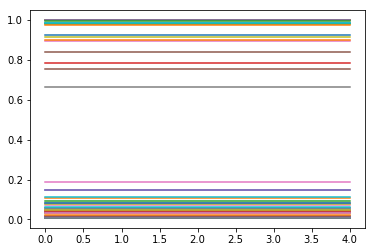

In [140]:
plt.plot([k for k in best_model.predict(np.reshape(data[-5:], (5, 1, data.shape[1])))])
plt.show()